In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/study_DL/Study_DL

Mounted at /content/drive
/content/drive/MyDrive/study_DL/Study_DL


# 실습: 기온 예측 문제

## 데이터 불러오기

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
base_dir = '../필요데이터/jena_climate/'

fname = os.path.join(base_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [4]:
data[:500]

'"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"\n01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30\n01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10\n01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6'

In [5]:
climate_df = pd.read_csv(fname)
climate_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
climate_df.values.shape

(420551, 15)

In [7]:
climate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [8]:
header = climate_df.columns

values = climate_df.iloc[:,1:].values

### 기온 시각화

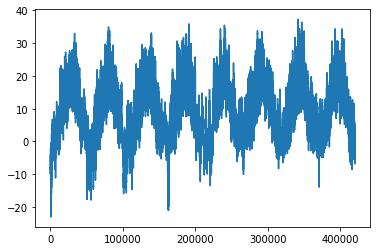

In [ ]:
import matplotlib.pyplot as plt

temp = values[:,1]

# 전체 기간 동안의 기온 시각화
plt.plot(range(len(temp)), temp)

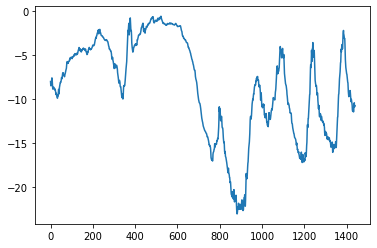

In [ ]:
# 10일 간의 기온 시각화(10분마다 데이터가 기록됨)

plt.plot(range(6*24*10), temp[:6*24*10])

- 전체 기간 데이터를 보면 기온의 주기성이 보임
- 10이 간의 데이터를 보면 솔직히 긴가민가하지만 마지막 3-4일 간 주기성을 띄는 것을 억지로 확인 가능했음(저걸 보고 주기성이 있다고 판단해야하는지 잘 모르겠음)
<br><br>
- 아무튼, 이렇게 오랜 기간의 데이터를 가지고 다음 달의 평균 옫ㄴ도를 예측하는 문제는 쉬운 편이라고 함
- 하지만, 하루하루 데이터를 살펴보면 온도 변화는 매우 불안정함. 일자별 수준의 시계열 데이터를 예측할 수 있을 지 실습해보겠음

## 데이터 준비

* 목표:
  - time step: 60분
  - lookback time step: 10일
  - delay: 24시간

일 때, 이 데이터를 바탕으로 dlay 타임스텝 이후의 온도 예측하는 모델 만들기

In [9]:
# 데이터 스케일링
## 피처 데이터마다 범위가 다르기 때문에 스케일링이 필요함

all_values = (values - values[:200000].mean(axis = 0))/values[:200000].std(axis = 0)
all_values.shape

(420551, 14)

In [10]:
# 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터 만들기

- data: 정규화한 부동 소수 데이터로 이루어진 원본 배열
- lookback: 거슬러 올라가기 위한 타임스텝
- delay: 타깃으로 사용할 미래의 타임스텝
- min_idx, max_idx: 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스, 검증/테스트 데이터 분리하는데 사용함
- shuffle: 샘플을 섞을지, 시간 순서대로 추출할지 결정
- batch_size: 배치 샘플 수
- step: 데이터 샘플링할 타임스텝 간격: 1시간에 한개씩으로하기 위해 6으로 지정

In [11]:
def generator(data, lookback, delay, min_idx, max_idx, shuffle = False, batch_size = 128, step = 6):
  if max_idx is None:
    max_idx = len(data) - delay - 1
  
  # 피처 단위 인덱스
  i = min_idx + lookback

  while 1:
    # shuffle이 true면, 행 인덱스 범위 내에서 배치 샘플수만큼 인덱스 추출
    if shuffle:
      rows = np.random.randint(min_idx + lookback, max_idx, size = batch_size)
    
    # false이고, 행 인덱스 +  
    else:
      if i + batch_size >= max_idx:
        i = min_idx + lookback

      rows = np.arange(i, min(i + batch_size, max_idx))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    # print(samples.shape)
    
    targets = np.zeros((len(rows),))
    # print(targets.shape)

    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]

    yield samples, targets

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(all_values,
                      lookback = lookback,
                      delay = delay,
                      min_idx = 0,
                      max_idx = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen = generator(all_values,
                    lookback = lookback,
                    delay = delay,
                    min_idx = 200001,
                    max_idx = 300000,
                    step = step,
                    batch_size = batch_size)

test_gen = generator(all_values,
                    lookback = lookback,
                    delay = delay,
                    min_idx = 300001,
                    max_idx = None,
                    step = step,
                    batch_size = batch_size)



In [13]:
val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(values) - 300001 - lookback) // batch_size

In [14]:
val_steps, test_steps

(769, 930)

## 상식적 기준 모델의 MAE 계산하기

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.28973597299054815


- 출력된 MAE는 .29임. 섭씨온도는 2.97도정도 될 듯
- 꽤 loss가 높은 편

## 기본적인 머신러닝 모델 만들기

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [ ]:
model = Sequential()

model.add(layers.Flatten(input_shape = (lookback // step, values.shape[-1] )))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))   # 회귀예측이므로 활성화함수 x


model.compile(optimizer = RMSprop(),
              loss = 'mae')


In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_steps = val_steps,
                    validation_data = val_gen)

Epoch 1/20
500/500 [==============================] - 12s 17ms/step - loss: 1.6871 - val_loss: 0.9249
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.6097 - val_loss: 0.5584
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3382 - val_loss: 0.3149
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2770 - val_loss: 0.3290
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2598 - val_loss: 0.3107
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2497 - val_loss: 0.3279
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2440 - val_loss: 0.3444
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2372 - val_loss: 0.3215
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2329 - val_loss: 0.3135
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2275 - val_l

### 시각화

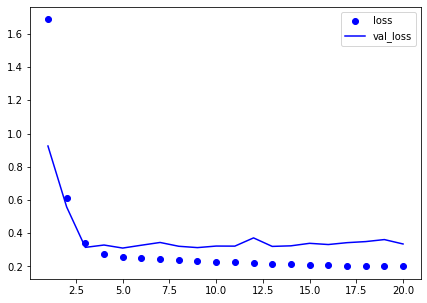

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, 21)

plt.figure(figsize = (7, 5))
plt.plot(epochs, loss, 'bo', label = 'loss')
plt.plot(epochs, val_loss, 'b', label = 'val_loss')
plt.legend()
plt.show()

- 검증 손실이 학습하지 않은 기준점보다 높게 나옴, 그래도 안정적이지 못함
- 그리고, flatten을 통해 시간적 의미를 잃어버린 모델이 됨
<br><br>
- 상식상의 기준 모델보다 학습한 모델의 성능이 낮은 이유는, 훈련 과정이 찾는 모델이 이러한 간단한 모델이 아니기 때문임
- 문제 해결을 위해 탐색하는 모델의 공간, 즉 가설 공간은 매개변수로 설정한 2개의 층을 가지는 네트워크의 모든 가중치 조합임
- 이미 이 네트워크는 복잡한 상태임
- 이게 일반적으로 머신러닝이 가진 심각한 제약사항!
- 학습 알고리즘이 특정한 종류의 간단한 모델을 찾도록 하드코딩 되지 않았다면, 모델 파라미터를 학습하는 방법은 간단한 문제를 위한 간략한 해결책을 찾지 못할 수 있음

## 순환 신경망 모델 만들기

### GRU 모델 만들기

In [20]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop

In [16]:
# 인과 관계와 순서가 의미 있는 시퀀스 데이터를 그대로 이용해 보기

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, all_values.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 18s 27ms/step - loss: 0.3069 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2866 - val_loss: 0.2691
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2805 - val_loss: 0.2642
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2759 - val_loss: 0.2659
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2710 - val_loss: 0.2644
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2657 - val_loss: 0.2667
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2607 - val_loss: 0.2638
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2573 - val_loss: 0.2640
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2529 - val_loss: 0.2741
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.248

#### 시각화

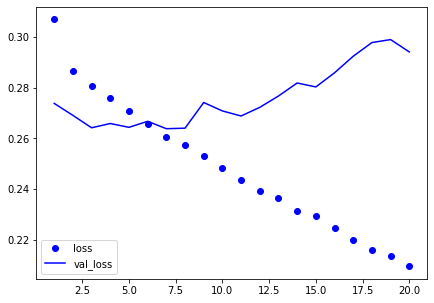

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, 21)

plt.figure(figsize = (7, 5))
plt.plot(epochs, loss, 'bo', label = 'loss')
plt.plot(epochs, val_loss, 'b', label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
min(val_loss), max(val_loss)

(0.26381510496139526, 0.2989564538002014)

- 과대적합이긴 하지만, 그래도 이전 완전연결층보다는 훨씬 성능이 좋아짐
- 그림이 y축 눈금이가 타이트해서 차이가 많이 커보이지만, 최소 손실이 0.26, 최대가 0.29로 상식수준의 모델을 앞지름^^

- 더 개선해보자

### 순환 드롭아웃 적용
- 과대적합을 해결하기 위한 방법 중 하나로 <b>드롭아웃</b>이 있음
- 하지만 RNN에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않음
- 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해되는 것으로 오랫동안 알려짐
- 2015년 야린 갈이 베이지안 딥러닝에 관한 박사논문에서 순환 네트워크에 적절하게 드롭아웃을 사용하는 방법을 알아냄
- <b>타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크(동일한 유닛의 드롭 패턴)를 모든 타임스텝에 적용</b>해야 함
-<b> GRU나 LSTM같은 순환 게이트에 의해 만들어지는 표현을 규제</b>하려면, <b>순환 층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 드롭아웃 마스크를 적용</b>해야 함(순환 드롭 아웃 마스크)
- 모든 타임스텝에 동일한 드롭아웃 마스크를 적용하면, 네트워크가 학습 오차를 타임스텝에 걸쳐 전파시킬 것
- 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼침
<br><br>
- 드롭아웃으로 규제된 네트워크는 언제나 완전히 수렴하는데 더 오래 걸리므로, 에포크를 두 배 늘려서 네트워크를 훈련하도록 하겠음

- 케라스에 있는 모든 순환 층은 2개의 드롭아웃 매개변수를 가짐
  - dropout: 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수값
  - recurrent_dropout: 순환 상태의 드롭아웃 비율을 정함

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [16]:
# 드롭아웃 규제된 GRU를 사용한 모델 훈련

model = Sequential()

model.add(layers.GRU(32, 
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     input_shape = (None, all_values.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(),
              loss = 'mae')

In [17]:
history2 = model.fit(train_gen,
                     epochs = 30,
                     steps_per_epoch = 500,
                     validation_data = val_gen,
                     validation_steps = val_steps)

Epoch 1/30
500/500 [==============================] - 476s 939ms/step - loss: 0.3265 - val_loss: 0.2775
Epoch 2/30
500/500 [==============================] - 451s 902ms/step - loss: 0.3044 - val_loss: 0.2717
Epoch 3/30
500/500 [==============================] - 455s 910ms/step - loss: 0.2970 - val_loss: 0.2832
Epoch 4/30
500/500 [==============================] - 453s 906ms/step - loss: 0.2915 - val_loss: 0.2710
Epoch 5/30
500/500 [==============================] - 448s 896ms/step - loss: 0.2862 - val_loss: 0.2709
Epoch 6/30
500/500 [==============================] - 443s 887ms/step - loss: 0.2829 - val_loss: 0.2682
Epoch 7/30
500/500 [==============================] - 438s 877ms/step - loss: 0.2775 - val_loss: 0.2707
Epoch 8/30
500/500 [==============================] - 442s 884ms/step - loss: 0.2752 - val_loss: 0.2801
Epoch 9/30
500/500 [==============================] - 441s 882ms/step - loss: 0.2747 - val_loss: 0.2773
Epoch 10/30
500/500 [==============================] - 439s 878m

#### 시각화

In [17]:
import matplotlib.pyplot as plt

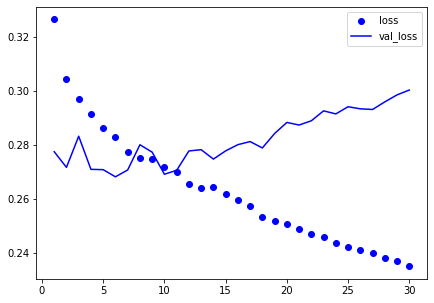

In [22]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']


epochs = range(1, 31)

plt.figure(figsize = (7, 5))
plt.plot(epochs, loss2, 'bo', label = 'loss')
plt.plot(epochs, val_loss2, 'b', label = 'val_loss')
plt.legend()
plt.show()

### 순환 층 스태킹하기
- 과대적합은 없지만, 일단 네트워크 층을 쌓을 때, 과대적합이 일어날 때까지 용량을 늘리는 것이 좋음
- 너무 과대적합이 되지 않는 한, 아직 충분한 용량에 도달한 것이 아님
- 네트워크 용량을 늘리려면, 유닛 수를 추가하거나, 층을 추가하는 방법이 있음
- 순환층 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법임

In [18]:
from keras.layers import GRU

In [19]:
model = Sequential()
model.add(GRU(32,
              dropout = 0.2,
              recurrent_dropout = 0.2,
              return_sequences = True,
              input_shape = (None, all_values.shape[-1])))
model.add(GRU(64,
              activation = 'relu',
              dropout = 0.1,
              recurrent_dropout = 0.5))
model.add(layers.Dense(1))


model.compile(optimizer = RMSprop(),
              loss = 'mae')


In [21]:
history3 = model.fit(train_gen,
                     epochs = 20,
                     steps_per_epoch = 500,
                     validation_data = val_gen,
                     validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 962s 2s/step - loss: 0.3148 - val_loss: 0.2781
Epoch 2/20
500/500 [==============================] - 953s 2s/step - loss: 0.3003 - val_loss: 0.2764
Epoch 3/20
500/500 [==============================] - 962s 2s/step - loss: 0.2923 - val_loss: 0.2700
Epoch 4/20
500/500 [==============================] - 988s 2s/step - loss: 0.2856 - val_loss: 0.2764
Epoch 5/20
500/500 [==============================] - 959s 2s/step - loss: 0.2769 - val_loss: 0.2739
Epoch 6/20
500/500 [==============================] - 958s 2s/step - loss: 0.2708 - val_loss: 0.2694
Epoch 7/20
500/500 [==============================] - 957s 2s/step - loss: 0.2652 - val_loss: 0.2834
Epoch 8/20
500/500 [==============================] - 956s 2s/step - loss: 0.2586 - val_loss: 0.2879
Epoch 9/20
500/500 [==============================] - 962s 2s/step - loss: 0.2565 - val_loss: 0.2889
Epoch 10/20
500/500 [==============================] - 965s 2s/step - loss: 0.2493 - val_lo